# Comparing Boosting Methods in `sklearn` 🚀

And among others:
- randomised grid search for hyperparameter tuning
- out-of-sample fit scoring

First importing the relevant libraries:

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
from plotnine import *

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

config_context(transform_output="pandas")

<img src="https://i.ytimg.com/vi/8MOtth7Vln8/hqdefault.jpg" alt="drawing" width="400"/>

Then, importing the training and testing data:

In [3]:
# import data
dt_train = pd.read_csv("train.csv").astype({"children":"category"})
dt_test = pd.read_csv("test.csv").astype({"children":"category"})

dt_train.head(3)

,age,sex,bmi,children,smoker,region,charges
0,61,female,25.08,0,no,southeast,24513.09126
1,41,male,29.64,5,no,northeast,9222.40260
2,25,male,26.22,0,no,northeast,2721.32080


### Exploratory Data Analysis 🖼️

Let's visualise the data first before building the models:

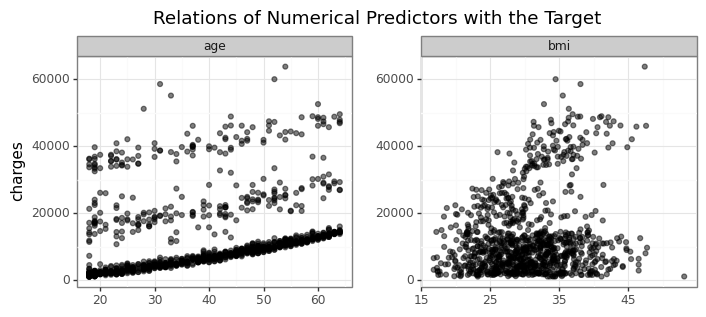

<ggplot: (141643800982)>

In [4]:
(
    ggplot(data=(dt_train.select_dtypes(include="number")
                 .melt(id_vars="charges")),
           mapping=aes(x="value", y="charges")) +
    geom_point(alpha=0.5) +
    facet_wrap("~ variable", scales="free") +
    labs(title="Relations of Numerical Predictors with the Target",
         x=None) +
    theme_bw() +
    theme(figure_size=[8, 3],
          subplots_adjust={"wspace": 0.25})
)


In [5]:
dt_train.select_dtypes(exclude="number").join(dt_train["charges"]).melt(id_vars="charges")

,charges,variable,value
0,24513.09126,sex,female
1,9222.40260,sex,male
2,2721.32080,sex,male
3,2104.11340,sex,male
4,5969.72300,sex,male
...,...,...,...
4007,10982.50130,region,southeast
4008,1964.78000,region,southwest
4009,1607.51010,region,southeast
4010,21774.32215,region,northwest


Average charges by nominal predictors:

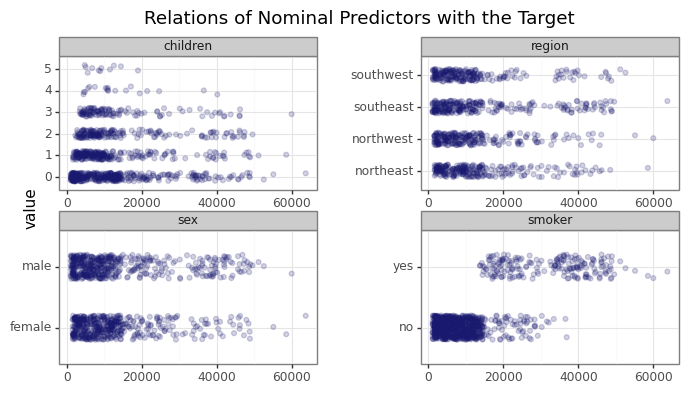

<ggplot: (141646093481)>

In [6]:
(
    ggplot(data=(dt_train.select_dtypes(exclude="number").join(dt_train["charges"])
                 .melt(id_vars="charges")),
           mapping=aes(x="charges", y="value")) +
    geom_jitter(height=0.2, alpha=0.2, colour="midnightblue") +
    labs(title="Relations of Nominal Predictors with the Target",
         x=None) +
    facet_wrap("~ variable", scales="free") +
    theme_bw() +
    theme(figure_size=[8, 4],
          subplots_adjust={"wspace": 0.4, "hspace": 0.3})
)


Average charges by nominal category:

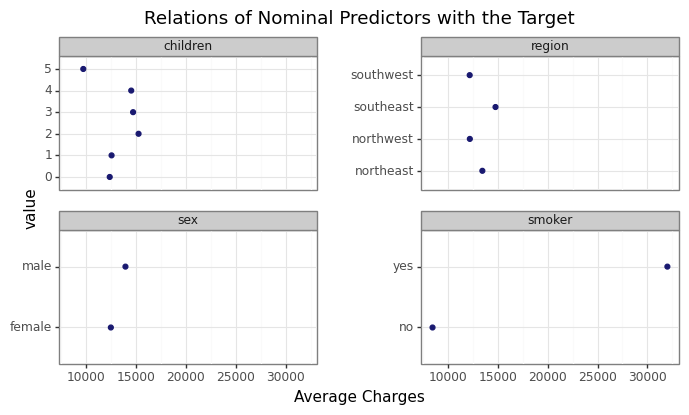

<ggplot: (141646325751)>

In [7]:
(
    ggplot(data=(dt_train
                 .select_dtypes(exclude="number")
                 .join(dt_train["charges"])
                 .melt(id_vars=["charges"])
                 .groupby(["variable", "value"])
                 .agg(mean_charges=("charges", "mean"))
                 .reset_index()
                 ),
mapping=aes(x="mean_charges", y="value")) +
    geom_point(colour="midnightblue") +
    labs(title="Relations of Nominal Predictors with the Target",
         x="Average Charges") +
    facet_wrap("~ variable", scales="free_y") +
    theme_bw() +
    theme(figure_size=[8, 4],
          subplots_adjust={"wspace": 0.4, "hspace": 0.3})
)


It looks like smokers get charged a lot more! Does that show in the numerical plot also?

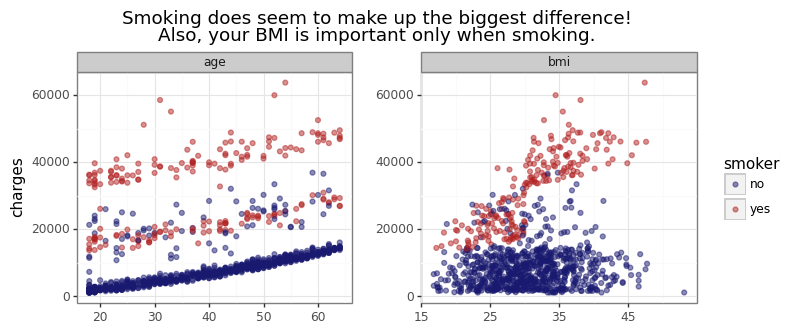

<ggplot: (141646468973)>

In [8]:
(
    ggplot(data=(dt_train
                 .select_dtypes(include="number")
                 .join(dt_train["smoker"])
                 .melt(id_vars=["charges", "smoker"])),
           mapping=aes(x="value", y="charges", colour="smoker")) +
    geom_point(alpha=0.5) +
    facet_wrap("~ variable", scales="free") +
    labs(title="Smoking does seem to make up the biggest difference!\nAlso, your BMI is important only when smoking.",
         x=None) +
    scale_colour_manual(values=["midnightblue", "firebrick"]) +
    theme_bw() +
    theme(figure_size=[8, 3],
          subplots_adjust={"wspace": 0.25})
)


### Building and Tuning an XGBoost and LGBM Model

In [9]:
X_train, y_train = dt_train.drop("charges", axis=1), dt_train["charges"]
X_test, y_test = dt_test.drop("charges", axis=1), dt_test["charges"]

In [10]:
# Convert objects to categories
for dataset in [X_train, X_test]:
    for col in dataset.select_dtypes(include="object").columns:
        dataset[col] = dataset[col].astype("category")

XGBoost and LightGBM require One-Hot Encoding. No missing values, only need to scale and onehot encode:

In [11]:
# Making column selectors for dtypes
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder()),
])

# Making column transformer
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_cols),
                  ("categorical", categorical_transformer, cat_cols)],
    remainder="passthrough"
)

# Making model pipeline for lightgbm
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("LGBMmodel", LGBMRegressor())
])

xg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("XGmodel", XGBRegressor())
])


In [12]:
# see transformed dataset
pd.DataFrame(xg_pipeline[:-1].fit_transform(X_train, y_train),
             columns=xg_pipeline[:-1].get_feature_names_out())


,numeric__age,numeric__bmi,categorical__sex_female,categorical__sex_male,categorical__children_0,categorical__children_1,categorical__children_2,categorical__children_3,categorical__children_4,categorical__children_5,categorical__smoker_no,categorical__smoker_yes,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest
0,1.563678,-0.919141,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.137564,-0.167432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-1.003328,-0.731214,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.288551,-0.543287,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.208870,-0.619117,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,1.278455,1.601392,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
999,-1.359856,-1.426874,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1000,-1.502468,-1.626341,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1001,0.280175,-0.621590,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Hyperparameter tuning: LGBM

In [16]:
# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
lgbm_grid = {
    'LGBMmodel__num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    'LGBMmodel__max_depth': [int(x) for x in np.linspace(start=1, stop=100, num=20)],
    # 'LGBMmodel__learning_rate' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5],
    'LGBMmodel__subsample' : [0.4, 0.6, 0.8, 1]
}

lgbm_search = (RandomizedSearchCV(lgbm_pipeline, param_distributions=lgbm_grid, n_iter=200,
                                  verbose=1, cv=3, scoring="neg_mean_squared_error")
               .fit(X_train, y_train))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [17]:
# Select the hyperparams and the score from the results
lgbm_search_results = (pd.DataFrame(lgbm_search.cv_results_)
                       .filter(["param_" + x for x in list(lgbm_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
lgbm_search_results.columns = lgbm_search_results.columns.str.replace("param_LGBMmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
lgbm_search_results.describe()


,mean_test_score
count,2.000000e+02
mean,-2.591089e+07
std,4.444187e+06
min,-3.692251e+07
25%,-2.514230e+07
50%,-2.514230e+07
75%,-2.414074e+07
max,-2.145039e+07


In [18]:
lgbm_search.best_params_

{'LGBMmodel__subsample': 0.8,
 'LGBMmodel__num_leaves': 4,
 'LGBMmodel__max_depth': 11}

### Hyperparameter tuning: XGBoost

In [19]:
# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
xg_grid = {
    'XGmodel__max_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    'XGmodel__min_split_loss': [round(x, ndigits=5) for x in np.linspace(start=0, stop=100, num=20)],
    'XGmodel__learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5],
    'XGmodel__subsample': [0.4, 0.6, 0.8, 1]
}

xg_search = (RandomizedSearchCV(xg_pipeline, param_distributions=xg_grid, n_iter=200,
                                verbose=1, cv=3, scoring="neg_mean_squared_error", error_score="raise")
             .fit(X_train, y_train))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [20]:
# Select the hyperparams and the score from the results
xg_search_results = (pd.DataFrame(xg_search.cv_results_)
                       .filter(["param_" + x for x in list(xg_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
xg_search_results.columns = xg_search_results.columns.str.replace("param_XGmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
xg_search_results.describe()


,mean_test_score
count,2.000000e+02
mean,-1.931484e+08
std,1.296314e+08
min,-3.180323e+08
25%,-3.129910e+08
50%,-2.662510e+08
75%,-3.327334e+07
max,-2.546942e+07


In [21]:
xg_search.best_params_

{'XGmodel__subsample': 0.4,
 'XGmodel__min_split_loss': 73.68421,
 'XGmodel__max_leaves': 4,
 'XGmodel__learning_rate': 0.1}

### Model Evaluation on Test Data:

In [22]:
# Print the metrics for LGBM
print("LGBM Final Fit Metrics:")
print("--------------------------------")
print(f"R-Squared: {r2_score(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")

LGBM Final Fit Metrics:
--------------------------------
R-Squared: 0.8790105056663662
MAE: 2314.975874917336
MAPE: 0.2741630701454487


Compared to no tuning:

In [23]:
print(r2_score(y_pred=lgbm_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))
print(mean_absolute_error(y_pred=lgbm_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))
print(mean_absolute_percentage_error(y_pred=lgbm_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))


0.865443414932083
2555.8266870148336
0.3251270993504258


In [164]:
# Print the metrics for XGB
print("XGBoost Final Fit Metrics:")
print("--------------------------------")
print(f"R-Squared: {r2_score(y_pred=xg_search.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=xg_search.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=xg_search.predict(X_test), y_true=y_test)}")

XGBoost Final Fit Metrics:
--------------------------------
R-Squared: 0.8619953189371611
MAE: 2597.4910423583838
MAPE: 0.3207349763893007


In [25]:
# Compared to no tuning:
print(r2_score(y_pred=xg_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))
print(mean_absolute_error(y_pred=xg_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))
print(mean_absolute_percentage_error(y_pred=xg_pipeline.fit(X_train, y_train).predict(X_test), y_true=y_test))


0.8334400636802267
2975.6526215350104
0.3859308347476868


The tuning was more important for XGBoost than for LGBM. Fit times were much faster with LGBM and it also yielded better results on this data set.

In [26]:
predictions = pd.concat(
    [pd.DataFrame({"predictions": xg_search.predict(X_test),
                   "truth": y_test,
                   "model": "XGBoost"}),
     pd.DataFrame({"predictions": lgbm_search.predict(X_test),
                   "truth": y_test,
                   "model": "LGBM"})],
    axis=0)


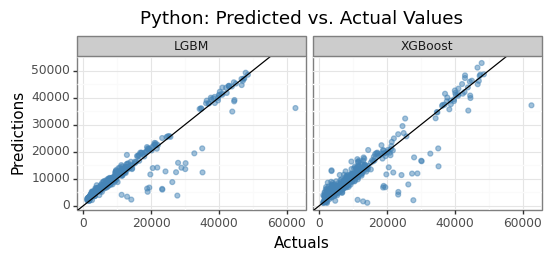

<ggplot: (141646744850)>

In [28]:
p = (
    ggplot(data=predictions, mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="Python: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    facet_wrap("~ model") +
    theme_bw() +
    theme(figure_size=[6, 2])
)

p


Looks a lot better with LGBM, even though $R^2$ is not that much higher!

In [29]:
(p + theme(figure_size=[4,4])).save(dpi=350, filename="python.png")

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png
